In [1]:
%load_ext autoreload
%autoreload 2

In [34]:
!pip install scipy

## Importing require dependencies and starting a spark context.

In [2]:
from pyspark import SparkContext
sc = SparkContext(pyFiles=['lib/numpy_pack.py','lib/row_parser.py','lib/spark_PCA.py'])

from pyspark.sql import Row, SQLContext,DataFrame
from pyspark.sql.types import *

sqlContext = SQLContext(sc)

%pylab inline

#!pip install pandas
#!pip install scipy

import pandas as pd
import datetime as dt

from scipy.io import loadmat,savemat,whosmat

from string import split
from collections import Counter
import re
import numpy as np
from numpy import shape

from glob import glob
from time import time

Populating the interactive namespace from numpy and matplotlib


## Loading the Dataset and Parsing the Rows

In [3]:
import sys
sys.path.append('lib')
from row_parser import *

Parse_rules,field_names,RowObject = init_parser_parameters()

from pyspark.sql import DataFrame

CVS_Data=sc.textFile("/CVS/*/")


def parse(row):
    items=row.split(',')
    D=[]
    for pr in Parse_rules:
        start=pr['start']
        end=pr['end']
        parser=pr['parser']
        if end-start==1:
            D.append(parser(items[start]))
        else:
            D.append(parser(items[start:end]))
    return RowObject(*D)


RDD=CVS_Data.map(parse)

df=sqlContext.createDataFrame(RDD)

('time', 'datetime') {'start': 0, 'parser': <function parse_date at 0x7fbb6703d398>, 'end': 1, 'name': 'time'}
('species', 'str') {'start': 1, 'parser': <function parse_string at 0x7fbb6703d578>, 'end': 2, 'name': 'species'}
('site', 'str') {'start': 2, 'parser': <function parse_string at 0x7fbb6703d578>, 'end': 3, 'name': 'site'}
('rec_no', 'str') {'start': 3, 'parser': <function parse_string at 0x7fbb6703d578>, 'end': 4, 'name': 'rec_no'}
('bout_i', 'int') {'start': 4, 'parser': <function parse_int at 0x7fbb6703d488>, 'end': 5, 'name': 'bout_i'}
('peak2peak', 'float') {'start': 5, 'parser': <function parse_float at 0x7fbb6703d500>, 'end': 6, 'name': 'peak2peak'}
('MSN', 'array', 202) {'start': 6, 'parser': <function parse_array at 0x7fbb6703d410>, 'end': 208, 'name': 'MSN'}
('MSP', 'array', 101) {'start': 208, 'parser': <function parse_array at 0x7fbb6703d410>, 'end': 309, 'name': 'MSP'}
('TPWS1', 'bool') {'start': 309, 'parser': <function parse_int at 0x7fbb6703d488>, 'end': 310, 'n

In [4]:
## Caching the Dataframe
df.cache().count()

6353182

## Functions to Read MSP

In [5]:
from spark_PCA import *
from row_parser import unpackArray

def trimmed_spectra(row):
    return unpackArray(row.MSP,data_type=numpy.float64)[12:85]

def unpackArray(x,data_type=numpy.int16):
    return np.frombuffer(x,dtype=data_type)

## Eigen Vector Extraction

shape of E= (73,) shape of NE= (73,)


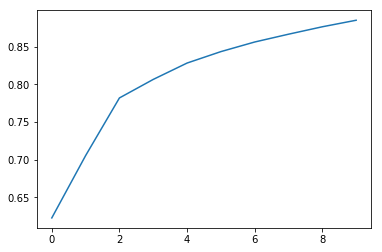

In [6]:
## Get Spectra
spectra=df.rdd.map(trimmed_spectra)

## Extract Eigen Vectors
COV=computeCov(spectra)
eigval,eigvec=LA.eig(COV['Cov'])
eigval=eigval/sum(eigval)

## Check the Reconstruction
plot(cumsum(eigval[:10]))

In [7]:
## Using First 5 Eigen Vectors
V=eigvec[:,0:5]

## Defining a function to return Projection
def project(array):
    return np.dot(array, V)

## Interclick Interval

Writing a UDF to get timestamp with higher precision to calculate Interclick Interval

In [8]:
from pyspark.sql.window import Window
from pyspark.sql.functions import udf, lag, collect_list, col
from pyspark.sql.types import DoubleType

def unix_ts(x):
    from datetime import datetime
    y = datetime.utcfromtimestamp(0)
    return (x-y).total_seconds()

unix_ts_udf = udf(unix_ts, DoubleType())

Calculating ICI for a given window of bout by sorting them by unix_ts

In [9]:
df_with_unix_ts = df.withColumn("unix_ts", unix_ts_udf(df.time))
df_with_ici = df_with_unix_ts.withColumn("ici",
                                         df_with_unix_ts.unix_ts - lag(df_with_unix_ts.unix_ts, 1).over(
                                             Window.partitionBy("bout_i").orderBy("unix_ts")
                                         ))

Calculating ICI per bout by taking median of all the ICI's in the given bout.

In [39]:
def median(values_list):
    med = np.median(values_list)
    return float(med)

udf_median = udf(median, FloatType())

lookup_grouped = df_with_ici.groupby(['bout_i'])
lookup = lookup_grouped.agg(udf_median(collect_list('ici')).alias('median_ici'))
lookup.cache()

DataFrame[bout_i: bigint, median_ici: float]

In [40]:
df_final = df_with_ici.alias('a').join(lookup.alias('b'), col('b.bout_i') == col('a.bout_i'))
df_final.cache().count()

6353182

## Defining Features

In [41]:
def features(row):
    array = trimmed_spectra(row)
    rmse = np.std(array)
    projections = project(array)
    ici = row.median_ici
    #return projections
    
    return np.hstack((projections, [rmse,ici]))

## Creating Training and Test Data

### Filtering Samples

Only taking the samples which were neither Misclassified (MS = 0) nor Falsely Detected (FD = 0)

In [42]:
df_filtered = df_final.filter(df_final.TPWS2==1).filter(df.MD2==0)
Cuviers=df_filtered.filter(df.species==u'Cuviers')
Gervais=df_filtered.filter(df.species==u'Gervais')

### Feature Extraction

In [43]:
Cuvier_projections=Cuviers.rdd.map(features)
Gervais_projections=Gervais.rdd.map(features)

### Adding Labels

In [44]:
from pyspark.mllib.regression import LabeledPoint
Cuvier_samples = Cuvier_projections.map(lambda features:LabeledPoint(1, features))
Gervais_samples = Gervais_projections.map(lambda features:LabeledPoint(0, features))

Sample Check

In [45]:
Cuvier_samples.take(1)

[LabeledPoint(1.0, [-247.945001823,12.1967355672,-52.5276591306,1.52922596785,19.4328757502,10.2998135252,0.305983066559])]

In [46]:
Gervais_samples.take(1)

[LabeledPoint(0.0, [-107.616674185,120.598920958,-49.9186256554,-0.487264499496,13.4123131985,10.7621986414,0.305983066559])]

### Creating Training and Test Data

Splitting the randomly shuffled dataset in 80/20 split for traning and testing

In [47]:
samples = Cuvier_samples.union(Gervais_samples)
[training_data, test_data] = samples.randomSplit([0.8, 0.2])
training_data.cache()
test_data.cache()

PythonRDD[2154] at RDD at PythonRDD.scala:48

### Defining Score Metrics

Accuracy is being used as a scoring function

In [48]:
def score(data, model):
    predictions = model.predict(data.map(lambda x: x.features))
    labels_and_preds = data.map(lambda x: x.label).zip(predictions)
    accuracy = labels_and_preds.filter(lambda x: x[0] == x[1]).count() / float(data.count())
    return accuracy

### Logistic Regression Model

In [49]:
from pyspark.mllib.classification import LogisticRegressionWithSGD

algo = LogisticRegressionWithSGD()
model = algo.train(training_data)
print "Training Accuracy: ", score(training_data, model), ", Test Accuracy: ", score(test_data, model)

Training Accuracy:  0.738731991477 , Test Accuracy:  0.738330576026


## SVM Model

In [50]:
from pyspark.mllib.classification import SVMWithSGD

algo = SVMWithSGD()
model = algo.train(training_data)
print "Training Accuracy: ", score(training_data, model), ", Test Accuracy: ", score(test_data, model)

Training Accuracy:  0.728301275167 , Test Accuracy:  0.727752143179


## Decision Tree

In [51]:
from pyspark.mllib.tree import DecisionTree

algo = DecisionTree()
model = algo.trainClassifier(training_data,numClasses=2,categoricalFeaturesInfo={})
print "Training Accuracy: ", score(training_data, model), ", Test Accuracy: ", score(test_data, model)

Training Accuracy:  0.850178545014 , Test Accuracy:  0.85017295834


## Random Forest

In [52]:
from pyspark.mllib.tree import RandomForest

algo = RandomForest()
model = algo.trainClassifier(training_data,numClasses=2,categoricalFeaturesInfo={},numTrees=16)
print "Training Accuracy: ", score(training_data, model), ", Test Accuracy: ", score(test_data, model)

Training Accuracy:  0.841180045015 , Test Accuracy:  0.841499172808


## GB Trees

In [54]:
from pyspark.mllib.tree import GradientBoostedTrees

algo = GradientBoostedTrees()
model = algo.trainClassifier(training_data,categoricalFeaturesInfo={}, numIterations=20)
print "Training Accuracy: ", score(training_data, model), ", Test Accuracy: ", score(test_data, model)

Training Accuracy:  0.849904694651 , Test Accuracy:  0.850139269063
